This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs)

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [0]:
df = pd.read_csv("/content/AAPL10Y.csv")

In [3]:
df.head()

,date,close,volume,open,high,low
0,2019/06/03,173.30,40396070.0,175.60,177.92,170.27
1,2019/05/31,175.07,27043580.0,176.23,177.99,174.99
2,2019/05/30,178.30,21218410.0,177.95,179.23,176.67
3,2019/05/29,177.38,28481170.0,176.42,179.35,176.00
4,2019/05/28,178.23,27948160.0,178.92,180.59,177.91


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
df.shape

(2517, 6)

In [0]:
TRAIN_SPLIT = 1762

In [0]:
tf.random.set_seed(13)

<h1>Forecast a univariate time series</h1>
First, you will train a model using only a single feature (close), and use it to make predictions for that value in the future.

Let's first extract only the close from the dataset.

In [9]:
uni_data = df['close']
uni_data.index = pd.to_datetime(df['date'])
uni_data.head()

date
2019-06-03    173.30
2019-05-31    175.07
2019-05-30    178.30
2019-05-29    177.38
2019-05-28    178.23
Name: close, dtype: float64

Let's observe the data how it looks like 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b22c3cf28>],
      dtype=object)

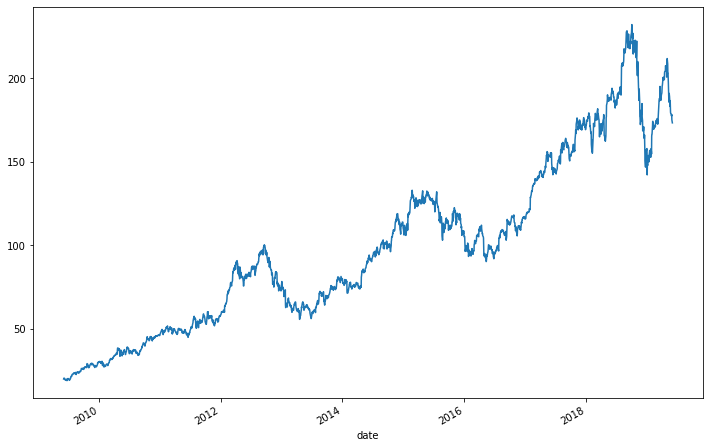

In [10]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 15 recorded close observations, and needs to learn to predict the close at the next time step.

In [0]:
univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[1.21817841]
 [1.25965056]
 [1.33533139]
 [1.31377524]
 [1.33369125]
 [1.35102989]
 [1.36719701]
 [1.44030047]
 [1.52980535]
 [1.44756395]
 [1.58603878]
 [1.61134383]
 [1.63102553]
 [1.57807238]
 [1.50918643]]

 Target temperature to predict
1.7777010700406235


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

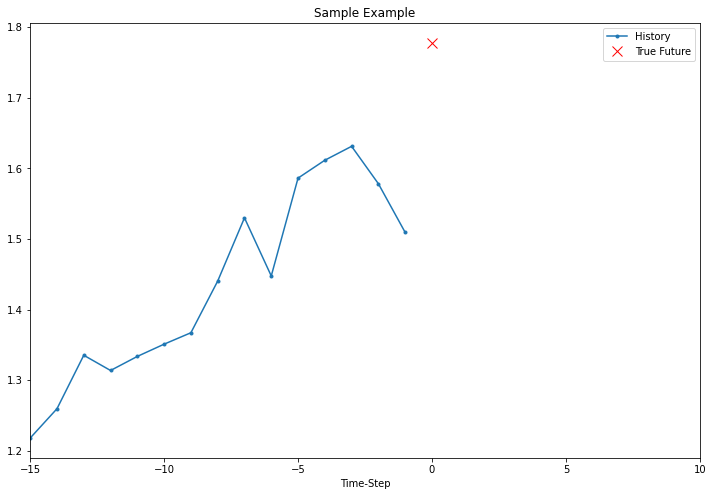

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 15 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

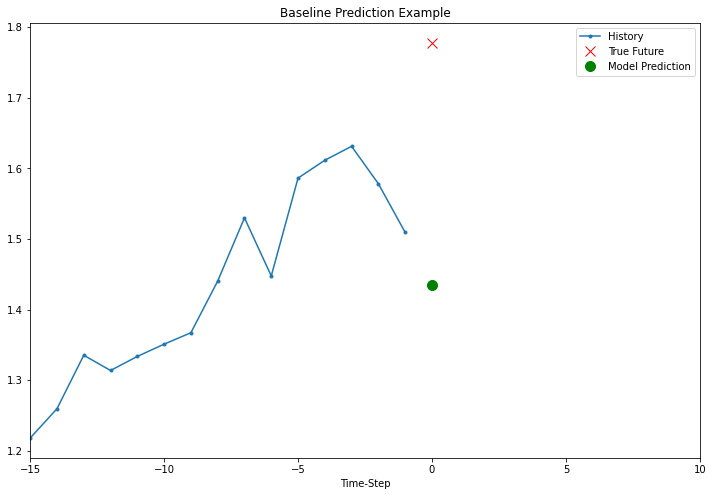

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

<h1>Recurrent neural network</h1>

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3296 - val_loss: 0.4794
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0734 - val_loss: 0.2768
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0531 - val_loss: 0.2047
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0482 - val_loss: 0.1658
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0449 - val_loss: 0.1363
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0417 - val_loss: 0.1186
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0393 - val_loss: 0.1015
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0375 - val_loss: 0.0863
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0362 - val_loss: 0.0739
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0353 - val_loss: 0.0746

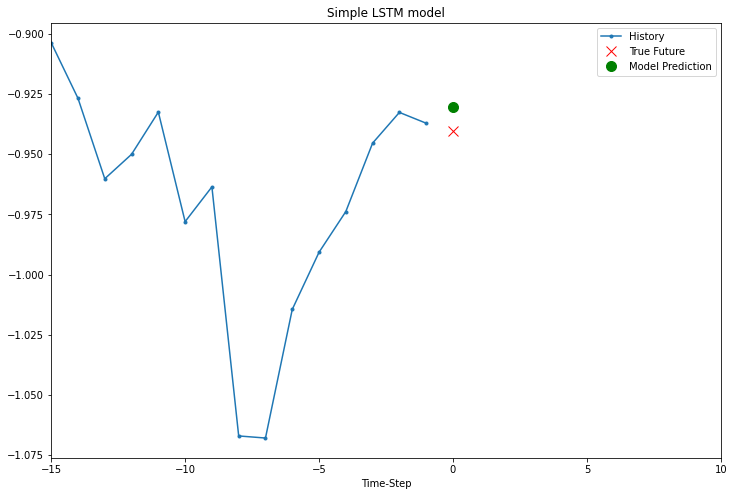

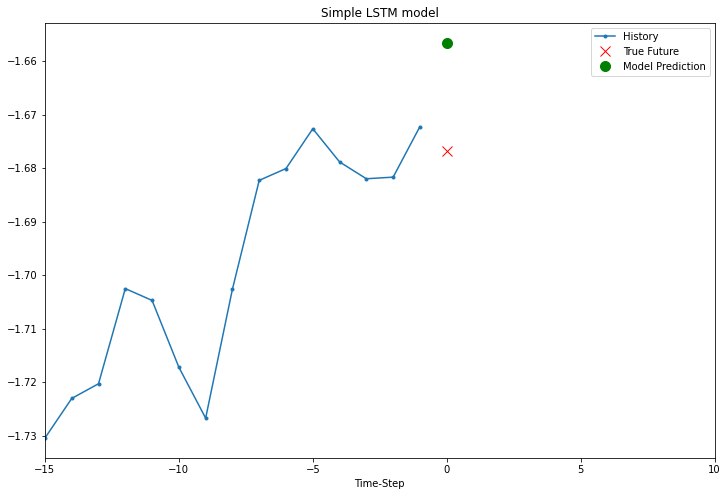

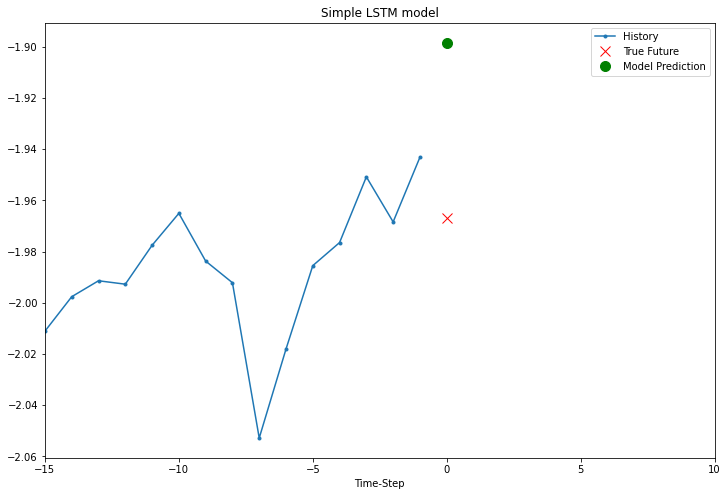

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

How Close our model is in predicting the future value